<a href="https://colab.research.google.com/github/ashishagg70/GANText2Image/blob/master/Text2FaceV6_BERT_wloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ! wget http://www.cs.toronto.edu/~rkiros/models/dictionary.txt
# ! wget http://www.cs.toronto.edu/~rkiros/models/utable.npy
# ! wget http://www.cs.toronto.edu/~rkiros/models/btable.npy
# ! wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz
# ! wget http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz.pkl
# ! wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz
# ! wget http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz.pkl

In [44]:
!gdown --id 1D4yFM5bLF2PEVlM_yXzTp-cLjGgNai2m
#!gdown --id 1UQNd2OsbuuW5QSfc6-78e0heJk3F3FeL
#!gdown --id 14a90ceynctKczgase-iVbS8ZbwcTZSOT
#!gdown --id 1d1Cfsz1BcdWE_b4eF8KG6tSa0efsKLZ0
#!gdown --id 19DTv9tXIby7FW8TnU69u8xbNpcTWx6RG
!unzip img_align_celeba.zip
# !unzip list_attr_celeba.csv.zip
#!unzip list_bbox_celeba.csv.zip
#!unzip list_eval_partition.csv.zip
#!unzip list_landmarks_align_celeba.csv.zip

Downloading...
From: https://drive.google.com/uc?id=1D4yFM5bLF2PEVlM_yXzTp-cLjGgNai2m
To: /content/img_align_celeba.zip
351MB [00:07, 34.7MB/s]Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/gdown/cli.py", line 61, in main
    quiet=args.quiet,
  File "/usr/local/lib/python2.7/dist-packages/gdown/download.py", line 101, in download
    for chunk in res.iter_content(chunk_size=CHUNK_SIZE):
  File "/usr/local/lib/python2.7/dist-packages/requests/models.py", line 751, in generate
    for chunk in self.raw.stream(chunk_size, decode_content=True):
  File "/usr/local/lib/python2.7/dist-packages/urllib3/response.py", line 492, in stream
    for line in self.read_chunked(amt, decode_content=decode_content):
  File "/usr/local/lib/python2.7/dist-packages/urllib3/response.py", line 668, in read_chunked
    self._update_chunk_length()
  File "/usr/local/lib/python2.7/dist-packages/urllib3/res

In [ ]:
!gdown --id 1VMBG_cAfbUZ7CJmzuQhkuPkSPBtkGOti #skipthoughts.py module for import ready python3.7
!gdown --id 1Z2nZ0sykKPn64BvzqrbwUjRFC4VqJAhm #annotated data Text2FaceAnnotation.json
!gdown --id 1SYFQOQ1LSlGCgsr3QnzxCN-LDuUjEnYv #skip thought vectors of dim 4800 of descriptions
!gdown --id 1KajlSVNK_UfPLnv5d-gNlwCSxcmkk4XO #filename in order of skip thought loaded

Downloading...
From: https://drive.google.com/uc?id=1VMBG_cAfbUZ7CJmzuQhkuPkSPBtkGOti
To: /content/skipthoughts.py
100% 13.9k/13.9k [00:00<00:00, 22.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Z2nZ0sykKPn64BvzqrbwUjRFC4VqJAhm
To: /content/Text2FaceAnnotation.json
100% 1.46M/1.46M [00:00<00:00, 92.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SYFQOQ1LSlGCgsr3QnzxCN-LDuUjEnYv
To: /content/image_data_skip_thought_vectors_of_descriptions.npy
109MB [00:00, 125MB/s]  
Downloading...
From: https://drive.google.com/uc?id=1KajlSVNK_UfPLnv5d-gNlwCSxcmkk4XO
To: /content/images_filename_in_order_of_skip_thought_vectors.txt
100% 62.5k/62.5k [00:00<00:00, 23.5MB/s]


In [45]:
import numpy as np
import torch
import sys
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
from nltk.tokenize import word_tokenize
from torchvision import datasets, transforms
from PIL import Image
from torchvision.transforms import ToPILImage
import torchvision.utils as vutil
import json
from collections import defaultdict
import skipthoughts
from importlib import reload 
import tqdm 
import os
reload(skipthoughts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

cuda


In [ ]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 4.7MB/s 
     |████████████████████████████████| 2.1MB 18.9MB/s 
     |████████████████████████████████| 1.2MB 37.6MB/s 
     |████████████████████████████████| 3.3MB 37.4MB/s 
     |████████████████████████████████| 901kB 41.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=33270a3970c79c97f71f8878977666bef0f55bc2c36413a84285893ed160d74b
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [46]:
from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('stsb-mpnet-base-v2')
#sentence_embeddings = model.encode(sentences) #give embedding of size 768

In [47]:
json_filename='Text2FaceAnnotation.json'
file=open(json_filename,'r')
data=json.load(file)
data_dict={}
data_list_filename=[]
data_list_sentence=[]
for i,jsonElement in enumerate(data):
  data_dict[jsonElement['filename']]=jsonElement['description']
  data_list_filename.append(jsonElement['filename'])
  data_list_sentence.append(jsonElement['description'])
  #data_list.append((jsonElement['filename'],jsonElement['description']))

In [ ]:
# list_attr_celeba_test = pd.read_csv("list_attr_celeba.csv")
# #list_attr_celeba_test.head(10)
# attributes_test = list_attr_celeba_test.iloc[:,1:].values
# attributes_test[attributes_test<0]=0
# #attributes_test=np.tile(attributes_test,6)

In [75]:
image_dir='./img_align_celeba/'
encoding_size = 768
compressed_encoding_size=256
z_features = 100
imagePixel=64
train_data_size=15000
std=0.5
mean=0.5
leakyRelu_slope = 0.2 #default = 0.1

In [76]:
transform = transforms.Compose([transforms.Resize(imagePixel),
                                transforms.CenterCrop(imagePixel),
                                transforms.ToTensor(),transforms.Normalize(mean=[mean,mean,mean],
                          std=[std,std,std])])

In [77]:
data_list_sentence_emb = model.encode(data_list_sentence)
data_list_sentence_emb.shape

(5685, 768)

In [78]:
images_attr_data = []
i=0
for filename, description_bert_emb in zip(data_list_filename, data_list_sentence_emb):
  image = Image.open(image_dir+filename).convert('RGB')
  x = transform(image).numpy()
  i=i+1
  images_attr_data.append((x,description_bert_emb))

In [79]:
def denorm(image):
    return (image*std)+mean

In [83]:
def wasserstein_loss(output, target):
 loss = torch.mean(output*target)*-1
 return loss

In [84]:
train_loader = torch.utils.data.DataLoader(
    images_attr_data,
    batch_size=64,
    shuffle=True,
    # collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
    drop_last = True
)


In [85]:
# def weights_init(m):
#     if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif type(m) == nn.BatchNorm2d:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [86]:
class nn_G(nn.Module):
    def __init__(self):
      super().__init__()
      self.no_of_conv_layers=np.log2(imagePixel//8).astype('int32')
      dim = imagePixel*8

      self.conv=[]
      self.bnorm=[]
      self.compressLinear = nn.Linear(encoding_size,compressed_encoding_size)
      #self.conv_start = nn.ConvTranspose2d(compressed_encoding_size+z_features,dim,4,stride=1, padding=0, bias=False)
      #self.bnorm_start = nn.BatchNorm2d(dim)
      self.linearProjectionStart=nn.Linear(compressed_encoding_size+z_features,dim*4*4) #and reshaped to 512*4*4 in Text2FaceGAN paper 

      for i in range(self.no_of_conv_layers):
        self.conv.append(nn.ConvTranspose2d(dim,dim//2,4,stride=2, padding=1, bias=False))
        self.bnorm.append(nn.BatchNorm2d(dim//2))
        dim = dim//2
      self.conv=nn.ModuleList(self.conv)
      self.bnorm=nn.ModuleList(self.bnorm)
      assert dim == imagePixel
      self.conv_final = nn.ConvTranspose2d(dim,3,4,stride=2, padding=1, bias=False)   
    

    def forward(self,textEncoding):
      batch_size = textEncoding.shape[0]
      t = self.compressLinear(textEncoding)
      t = nn.LeakyReLU(leakyRelu_slope)(t)
      z = torch.randn(batch_size,z_features).to(device)
      x = torch.hstack((z,t))
      
      x = self.linearProjectionStart(x)
      x = x.view(-1, imagePixel*8, 4, 4)
      # x = x.unsqueeze(-1).unsqueeze(-1)
      # x = self.conv_start(x)
      # x = self.bnorm_start(x)
      # x = nn.LeakyReLU(leakyRelu_slope)(x)

      for i in range(self.no_of_conv_layers):
        x = self.conv[i](x)
        x = self.bnorm[i](x)
        x = nn.LeakyReLU(leakyRelu_slope)(x)
 
      x = self.conv_final(x)
      x = nn.Tanh()(x)

      return x


In [87]:
nn_Gen = nn_G().to(device)
nn_Gen.apply(weights_init)
print(nn_Gen)

nn_G(
  (compressLinear): Linear(in_features=768, out_features=256, bias=True)
  (linearProjectionStart): Linear(in_features=356, out_features=8192, bias=True)
  (conv): ModuleList(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (bnorm): ModuleList(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_final): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [88]:
class nn_D(nn.Module):
    def __init__(self):
      super().__init__()

      self.no_of_conv_layers=np.log2(imagePixel//4).astype('int32')
      in_channel=3
      out_channel=64
      dim = imagePixel*16
      self.conv=[]
      self.bnorm=[]

      for i in range(self.no_of_conv_layers):
        self.conv.append(nn.Conv2d(in_channel,out_channel,4,stride=2, padding=1, bias=False))
        self.bnorm.append(nn.BatchNorm2d(out_channel))
        in_channel = out_channel
        out_channel = out_channel*2
      #resulting 512*4*4
      self.conv=nn.ModuleList(self.conv)
      self.bnorm=nn.ModuleList(self.bnorm)

      #self.conv_t = nn.ConvTranspose2d(encoding_size,features,4,stride=1, padding=0, bias=False)
      #self.bnorm_t = nn.BatchNorm2d(features)

      self.compressLinear = nn.Linear(encoding_size,compressed_encoding_size)
      self.conv_final = nn.Conv2d(in_channel+compressed_encoding_size,1,4, bias = False)

    def forward(self,x,t):
      for i in range(self.no_of_conv_layers):
        x = self.conv[i](x)
        x = self.bnorm[i](x)
        x = nn.LeakyReLU(leakyRelu_slope)(x)

      t = self.compressLinear(t)
      t = nn.LeakyReLU(leakyRelu_slope)(t)
      t = t.view(-1, compressed_encoding_size, 1, 1).repeat(1, 1, 4, 4)

      x = torch.cat((x,t),dim=1)
      x = self.conv_final(x)

      x=nn.Flatten()(x)
      #x = nn.Sigmoid()(x)
      x=x.squeeze(-1)

      return x


In [89]:
nn_Dis = nn_D().to(device)
nn_Dis.apply(weights_init)
for p in nn_Dis.parameters():
    p.data.clamp_(-0.01, 0.01)
print(nn_Dis)

nn_D(
  (conv): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (bnorm): ModuleList(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (compressLinear): Linear(in_features=768, out_features=256, bias=True)
  (conv_final): Conv2d(768, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [126]:
nn_Dis = torch.load('wgan_model_dis_V6')
nn_Gen = torch.load('wgan_model_gen_V6')
nn_Dis.train()
nn_Gen.train()

nn_G(
  (compressLinear): Linear(in_features=768, out_features=256, bias=True)
  (linearProjectionStart): Linear(in_features=356, out_features=8192, bias=True)
  (conv): ModuleList(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (bnorm): ModuleList(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_final): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [127]:
epochs = 150

learning_rate_dis = 0.00005
learning_rate_gen= 0.00005

flipRealAndFake=False
optimizer_gen = torch.optim.RMSprop(nn_Gen.parameters(),lr=learning_rate_gen)

optimizer_dis = torch.optim.RMSprop(nn_Dis.parameters(),lr=learning_rate_dis)

criterion = wasserstein_loss

real_label = 1
fake_label =-1
#criterion=wasserstein_loss

n_critic =5

In [128]:
rm ./gen/*

In [93]:
!zip Bert_wloss_gen2.zip gen/*

  adding: gen/fixed-0.jpg (deflated 7%)
  adding: gen/fixed-100.jpg (deflated 9%)
  adding: gen/fixed-101.jpg (deflated 7%)
  adding: gen/fixed-102.jpg (deflated 7%)
  adding: gen/fixed-103.jpg (deflated 7%)
  adding: gen/fixed-104.jpg (deflated 9%)
  adding: gen/fixed-105.jpg (deflated 8%)
  adding: gen/fixed-106.jpg (deflated 8%)
  adding: gen/fixed-107.jpg (deflated 8%)
  adding: gen/fixed-108.jpg (deflated 7%)
  adding: gen/fixed-109.jpg (deflated 9%)
  adding: gen/fixed-10.jpg (deflated 9%)
  adding: gen/fixed-110.jpg (deflated 7%)
  adding: gen/fixed-111.jpg (deflated 7%)
  adding: gen/fixed-112.jpg (deflated 7%)
  adding: gen/fixed-113.jpg (deflated 8%)
  adding: gen/fixed-114.jpg (deflated 9%)
  adding: gen/fixed-115.jpg (deflated 8%)
  adding: gen/fixed-116.jpg (deflated 8%)
  adding: gen/fixed-117.jpg (deflated 7%)
  adding: gen/fixed-118.jpg (deflated 7%)
  adding: gen/fixed-119.jpg (deflated 8%)
  adding: gen/fixed-11.jpg (deflated 9%)
  adding: gen/fixed-120.jpg (deflated 

In [174]:
i=0
for epoch in tqdm.notebook.tqdm(range(epochs)):
    for batch_idx, _data in enumerate(train_loader):
      _imgs, _attrs= _data
      _imgs = _imgs.to(device)
      _attrs = _attrs.to(device)
      if i < n_critic:
        optimizer_dis.zero_grad()
        out_real = nn_Dis(_imgs,_attrs)
        l = len(_attrs)
        real_tensor = torch.Tensor([real_label]*l).to(device)
        fake_tensor = torch.Tensor([fake_label]*l).to(device)

        #print(out_real.shape)
        if(batch_idx%3!=0 or not flipRealAndFake):
            loss_real = criterion(out_real,real_tensor)
        else:
            loss_real = criterion(out_real,fake_tensor)

        out_fake = nn_Dis(nn_Gen(_attrs),_attrs)

        if(batch_idx%3!=0 or not flipRealAndFake):
            loss_fake = criterion(out_fake,fake_tensor)
        else:
            loss_fake = criterion(out_fake,real_tensor)

        loss_dis=loss_real + loss_fake
        loss_dis.backward()
        optimizer_dis.step()

        for p in nn_Dis.parameters():
            p.data.clamp_(-0.01, 0.01)
        
        i+=1

      else:
        optimizer_gen.zero_grad()
        out_fake2 = nn_Dis(nn_Gen(_attrs),_attrs)
        loss_gen = criterion(out_fake2,real_tensor)
        loss_gen.backward()
        optimizer_gen.step()
        i=0
    with torch.no_grad():
        print("{}, out_real={},out_fake={},out_fake2={},loss_real={},loss_fake={},loss_gen={}".format(epoch, out_real.mean().item(),out_fake.mean().item(),out_fake2.mean().item(),loss_real.item(),loss_fake.item(),loss_gen.item()))
        os.makedirs('gen', exist_ok=True)
        gen_attr = torch.tensor(images_attr_data[100][1]).unsqueeze(dim=0).to(device)
        gen = denorm(nn_Gen(gen_attr))
        vutil.save_image(gen,'./gen/fixed-{}.jpg'.format(epoch))
        randomIndex=np.random.randint(0,len(images_attr_data))
        gen_attr_random = torch.tensor(images_attr_data[randomIndex][1]).unsqueeze(dim=0).to(device)
        gen2 = denorm(nn_Gen(gen_attr_random))
        vutil.save_image(gen2,'./gen/random-{}.jpg'.format(epoch))
    #img = ToPILImage()(gen.cpu())
    #img.save('./gen/{}.jpg'.format(epoch))



0, out_real=0.5577191710472107,out_fake=-0.08382561802864075,out_fake2=-0.47444242238998413,loss_real=-0.5577191710472107,loss_fake=-0.08382561802864075,loss_gen=0.47444242238998413
1, out_real=0.5832982063293457,out_fake=0.05284060537815094,out_fake2=-0.5228919982910156,loss_real=-0.5832982063293457,loss_fake=0.05284060537815094,loss_gen=0.5228919982910156
2, out_real=0.5212644338607788,out_fake=-0.25126129388809204,out_fake2=-0.48980313539505005,loss_real=-0.5212644338607788,loss_fake=-0.25126129388809204,loss_gen=0.48980313539505005
3, out_real=0.5196425914764404,out_fake=-0.24400684237480164,out_fake2=-0.4948420524597168,loss_real=-0.5196425914764404,loss_fake=-0.24400684237480164,loss_gen=0.4948420524597168
4, out_real=0.42270705103874207,out_fake=-0.38053736090660095,out_fake2=-0.47323596477508545,loss_real=-0.42270705103874207,loss_fake=-0.38053736090660095,loss_gen=0.47323596477508545
5, out_real=0.2934008836746216,out_fake=-0.4586033821105957,out_fake2=-0.1988237202167511,loss

KeyboardInterrupt: ignored

In [181]:

torch.save(nn_Dis, "wgan_model_dis_V6_311epoch")
torch.save(nn_Gen, "wgan_model_gen_V6_311epoch")

In [252]:
sent_ind=3
data_list_sentence[sent_ind]

'An middle-aged woman with short blonde hair. Her eyebrows are darker than her hair colour. Her eyes are brown and there is some dark make-up around them. Her lips are thick and they are full. She is smiling with her lips parted and her upper teeth are visible.'

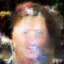

In [257]:
gen_attr = torch.tensor(images_attr_data[sent_ind][1]).unsqueeze(dim=0).to(device)
gen = denorm(nn_Gen(gen_attr)).squeeze()
img = ToPILImage()(gen.cpu())
img

In [102]:
transform2 = transforms.Compose([transforms.Resize(64),
                                 transforms.CenterCrop(64),
                                transforms.ToTensor()])

In [ ]:
attributes_test[171]

In [ ]:
x = transforms.functional.to_tensor(image)
print(x.shape)
img = ToPILImage()(x.cpu())
img

In [ ]:
#pd.set_option("display.max_columns",None)
#print(list_attr_celeba.head(11))
list_attr_celeba.iloc[100]


References:\
1. https://www.kaggle.com/jessicali9530/celeba-dataset?select=list_attr_celeba.csv \
2. https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/
3. https://towardsdatascience.com/getting-started-with-gans-using-pytorch-78e7c22a14a5
4. 

In [ ]:
while(1):
  pass

In [ ]:
!zip gen.zip gen/*

  adding: gen/fixed-0.jpg (deflated 4%)
  adding: gen/fixed-100.jpg (deflated 7%)
  adding: gen/fixed-101.jpg (deflated 7%)
  adding: gen/fixed-102.jpg (deflated 7%)
  adding: gen/fixed-103.jpg (deflated 7%)
  adding: gen/fixed-104.jpg (deflated 8%)
  adding: gen/fixed-105.jpg (deflated 7%)
  adding: gen/fixed-106.jpg (deflated 7%)
  adding: gen/fixed-107.jpg (deflated 7%)
  adding: gen/fixed-108.jpg (deflated 7%)
  adding: gen/fixed-109.jpg (deflated 7%)
  adding: gen/fixed-10.jpg (deflated 7%)
  adding: gen/fixed-110.jpg (deflated 7%)
  adding: gen/fixed-111.jpg (deflated 8%)
  adding: gen/fixed-112.jpg (deflated 7%)
  adding: gen/fixed-113.jpg (deflated 7%)
  adding: gen/fixed-114.jpg (deflated 7%)
  adding: gen/fixed-115.jpg (deflated 7%)
  adding: gen/fixed-116.jpg (deflated 7%)
  adding: gen/fixed-117.jpg (deflated 7%)
  adding: gen/fixed-118.jpg (deflated 7%)
  adding: gen/fixed-119.jpg (deflated 7%)
  adding: gen/fixed-11.jpg (deflated 8%)
  adding: gen/fixed-120.jpg (deflated 